In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt

from src.statistics.stats import compare_score, corrected_ci

In [2]:
df = pd.read_csv("../results/radiomics/rkf_results/light.csv")
df_combat = pd.read_csv("../results/radiomics/rkf_results/light_combat.csv")
df_fusion = pd.read_csv("../results/radiomics/rkf_results/light_fusion.csv")
df_dummy = pd.read_csv("../results/radiomics/rkf_results/dummy.csv")
df_suvmax = pd.read_csv("../results/radiomics/rkf_results/suvmax.csv")
df_size = pd.read_csv("../results/radiomics/rkf_results/light_fusion_size_analysis.csv")

In [3]:
df_plot = df_size[df_size["voi"]=="GTV_L"]
df_plot["1/n_train"] = df_plot["n_train"].map(lambda x: 1/x)

/home/valentin/python_wkspce/plc_segmentation/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
df_plot.groupby("1/n_train").mean()

,Unnamed: 0,accuracy,n_test,n_train,npv,precision,roc_auc,sensitivity,specificity,split
1/n_train,,,,,,,,,,
0.011111,749.5,0.772545,10.6,90.0,0.759278,0.813373,0.841190,0.837143,0.6700,49.5
0.012500,649.5,0.776455,10.6,80.0,0.776464,0.804967,0.823738,0.849762,0.6600,49.5
0.014286,549.5,0.768000,10.6,70.0,0.757798,0.808790,0.830631,0.826667,0.6755,49.5
0.016667,449.5,0.757273,10.6,60.0,0.729619,0.801012,0.802619,0.816667,0.6620,49.5
0.020000,349.5,0.747273,10.6,50.0,0.723325,0.800806,0.781810,0.799762,0.6615,49.5
0.025000,249.5,0.740000,10.6,40.0,0.711238,0.794671,0.782589,0.792857,0.6570,49.5
0.033333,149.5,0.724091,10.6,30.0,0.654508,0.798487,0.775744,0.767857,0.6535,49.5
0.050000,49.5,0.698091,10.6,20.0,0.655187,0.779344,0.760131,0.735000,0.6385,49.5


In [5]:
linear_model = np.polyfit(df_plot["1/n_train"].values,
                          df_plot["roc_auc"].values, 1)
linear_model_fn = np.poly1d(linear_model)


In [6]:
linear_model_fn(1/10)

0.6520312632718551

In [7]:
linear_model

array([-1.91572872,  0.84360414])

<AxesSubplot:xlabel='1/n_train', ylabel='roc_auc'>

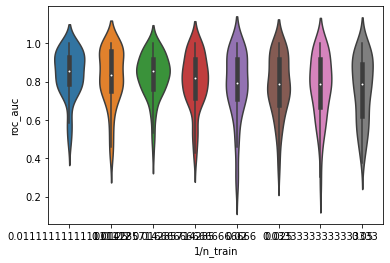

In [8]:
sns.violinplot(x="1/n_train", y="roc_auc", data=df_plot)

In [9]:
df_fcounts = pd.read_csv("../results/radiomics/rkf_results/light_feature_counts.csv")

In [10]:
df_f_hist = df_fcounts[(df_fcounts["modality"] == "PT")
                       & (df_fcounts["voi"] == "GTV_L") &
                       (df_fcounts["feature_count"] != 0.0)].sort_values(
                           by="feature_count")
df_f_hist.drop(["Unnamed: 0"], axis=1)

,feature_name,feature_count,modality,voi
303,original_glcm_SumSquares,1.0,PT,GTV_L
287,original_glcm_Correlation,5.0,PT,GTV_L
290,original_glcm_DifferenceVariance,6.0,PT,GTV_L
267,log-sigma-5-0-mm-3D_firstorder_Maximum,13.0,PT,GTV_L
270,log-sigma-5-0-mm-3D_firstorder_RobustMeanAbsol...,22.0,PT,GTV_L
272,log-sigma-5-0-mm-3D_firstorder_Variance,39.0,PT,GTV_L
278,original_firstorder_Minimum,85.0,PT,GTV_L
276,original_firstorder_Maximum,90.0,PT,GTV_L
302,original_glcm_SumEntropy,100.0,PT,GTV_L


In [11]:
df[(df["modality"] == "CT") & (df["voi"] == "GTV_L")].mean()

Unnamed: 0     49.500000
accuracy        0.771909
n_test         10.600000
n_train        95.400000
npv             0.762714
precision       0.801768
roc_auc         0.831083
sensitivity     0.846190
specificity     0.654500
split          49.500000
dtype: float64

In [12]:
df[(df["modality"] == "PT") & (df["voi"] == "GTV_L")].mean()

Unnamed: 0     349.500000
accuracy         0.793091
n_test          10.600000
n_train         95.400000
npv              0.780659
precision        0.839389
roc_auc          0.842321
sensitivity      0.841667
specificity      0.717000
split           49.500000
dtype: float64

In [13]:
df = pd.concat([df, df_fusion], axis=0)

In [14]:
df[(df["modality"] == "CT") & (df["voi"] == "GTV_N")].mean()


Unnamed: 0     249.500000
accuracy         0.689182
n_test          10.600000
n_train         95.400000
npv              0.673333
precision        0.712167
roc_auc          0.654298
sensitivity      0.845238
specificity      0.441000
split           49.500000
dtype: float64

In [15]:
df_dummy["modality"] = "random"
df_dummy["voi"] = df_dummy["strategy"].map(lambda x: "most_frequent" if x=="prior" else x)

In [16]:
df_tot = pd.concat([df, df_dummy[df_dummy["voi"]!="most_frequent"], df_suvmax], axis=0)

In [17]:
df_tot[(df_tot["modality"] == "SUVmax") & (df_tot["voi"] == "GTV_L")].mean()

Unnamed: 0     49.500000
accuracy        0.774091
n_test         10.600000
n_train        95.400000
npv             0.760333
precision       0.804591
roc_auc         0.799714
sensitivity     0.846190
specificity     0.660000
split          49.500000
strategy             NaN
dtype: float64

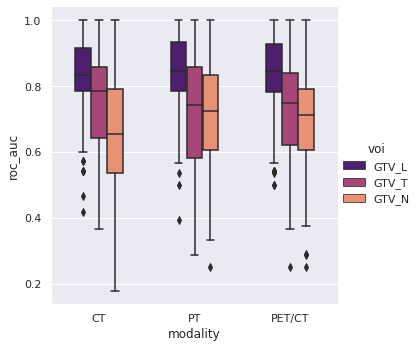

In [18]:
sns.set(rc={"figure.figsize":(18, 18)}) #width=8, height=4
ax = sns.catplot(x="modality", y="roc_auc", hue="voi", data=df, kind="box", palette="magma", width=0.5)
plt.savefig("/home/valentin/python_wkspce/plc_segmentation/reports/figures/results_ptct.png")

In [19]:
df[(df["modality"]=="PET/CT")&(df["voi"]=="GTV_L")].mean()

Unnamed: 0     49.500000
accuracy        0.775364
n_test         10.600000
n_train        95.400000
npv             0.775206
precision       0.808964
roc_auc         0.832405
sensitivity     0.848333
specificity     0.659000
split          49.500000
dtype: float64

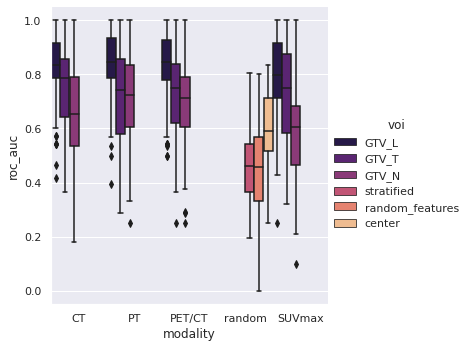

In [20]:
sns.set(rc={"figure.figsize":(8, 9)}) #width=8, height=4
ax = sns.catplot(x="modality", y="roc_auc", hue="voi", data=df_tot, kind="box", palette="magma", width=1.0)

In [21]:
df_tot[df_tot["voi"]=="random_features"].mean()

Unnamed: 0     249.500000
accuracy         0.503091
n_test          10.600000
n_train         95.400000
npv              0.303286
precision        0.581054
roc_auc          0.449869
sensitivity      0.655714
specificity      0.263500
split           49.500000
dtype: float64

In [22]:
df_tot["modality"].unique()

array(['CT', 'PT', 'PET/CT', 'random', 'SUVmax'], dtype=object)

In [23]:
df_catplot = df_tot[df_tot["modality"].isin(["PET/CT"])]
translate_voi = {
    "GTV_L": "VOI L",
    "GTV_T": "VOI T",
    "GTV_N": "VOI N",
}
df_catplot["voi"] = df_catplot["voi"].map(lambda x: translate_voi[x])

/home/valentin/python_wkspce/plc_segmentation/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
from matplotlib.markers import TICKDOWN


def significance_bar(start,
                     end,
                     height,
                     displaystring,
                     linewidth=1.2,
                     markersize=8,
                     boxpad=0.3,
                     fontsize=15,
                     color='k'):
    # draw a line with downticks at the ends
    plt.plot(
        [start, end],
        [height] * 2,
        '-',
        color=color,
        lw=linewidth,
        marker=TICKDOWN,
        markeredgewidth=linewidth,
        markersize=markersize,
        clip_on=False,
    )
    # draw the text with a bounding box covering up the line
    plt.text(0.5 * (start + end),
             height,
             displaystring,
             ha='center',
             va='center',
             bbox=dict(facecolor='1.',
                       edgecolor='none',
                       boxstyle='Square,pad=' + str(boxpad)),
             size=fontsize)


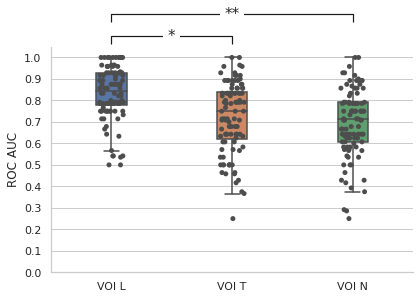

In [25]:
sns.set_style("whitegrid")
g = sns.catplot(x="voi",
                y="roc_auc",
                data=df_catplot,
                kind="box",
                fliersize=0.0,
                width=0.25,
                height=4,
                aspect=1.5)
g = sns.stripplot(x="voi", y="roc_auc", data=df_catplot, color="0.3")
g.set(ylabel='ROC AUC', xlabel='')
g.set_yticks(ticks=[0.1*k for k in range(11)])
g.set(ylim=(0.0, 1.05))
# plt.plot([1,2],[1.1,1.1], '|-k')
significance_bar(0,
                 1,
                 1.1,
                 "*",
                 linewidth=1.2,
                 markersize=8,
                 boxpad=0.3,
                 fontsize=15,
                 color='k')
significance_bar(0,
                 2,
                 1.2,
                 "**",
                 linewidth=1.2,
                 markersize=8,
                 boxpad=0.3,
                 fontsize=15,
                 color='k')
plt.savefig("petct_auc.png", dpi=200, bbox_inches="tight")

In [26]:
df_catplot = df_tot[df_tot["voi"]=="GTV_L"]
translate_modality = {
    "PT": "PET",
    "PET/CT": "PET/CT",
    "CT": "CT",
    "SUVmax": "SUV$_{max}$",
}
df_catplot["modality"] = df_catplot["modality"].map(lambda x: translate_modality[x])

/home/valentin/python_wkspce/plc_segmentation/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


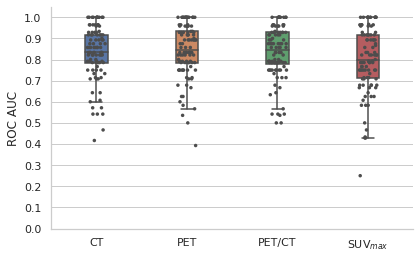

In [27]:
sns.set_style("whitegrid")
g = sns.catplot(x="modality",
                y="roc_auc",
                data=df_catplot,
                kind="box",
                fliersize=0.0,
                width=0.25,
                height=4,
                aspect=1.5)
g = sns.stripplot(x="modality", y="roc_auc", data=df_catplot, color="0.3", size=3.5)
g.set(ylabel='ROC AUC', xlabel='')
g.set_yticks(ticks=[0.1*k for k in range(11)])
g.set(ylim=(0.0, 1.05))
# plt.plot([1,2],[1.1,1.1], '|-k')

plt.savefig("gtvl_auc.png", dpi=200, bbox_inches="tight")

In [40]:
df_tot.columns

Index(['Unnamed: 0', 'accuracy', 'n_test', 'n_train', 'npv', 'precision',
       'roc_auc', 'sensitivity', 'specificity', 'split', 'modality', 'voi',
       'strategy'],
      dtype='object')

In [47]:
s1 = df_tot.loc[(df_tot["modality"]=="PET/CT") & (df_tot["voi"]=="GTV_L"), "roc_auc"].values
s2 = df_tot.loc[(df_tot["modality"]=="SUVmax") & (df_tot["voi"]=="GTV_L"), "roc_auc"].values

In [48]:
n_train = df_tot.loc[(df_tot["modality"]=="PET/CT") & (df_tot["voi"]=="GTV_L"), "n_train"].mean()
n_test = df_tot.loc[(df_tot["modality"]=="PET/CT") & (df_tot["voi"]=="GTV_L"), "n_test"].mean()

In [49]:
s = compare_score(s1, s2, n_train, n_test)
print(s)

{'t_stat': 0.7755348426381398, 'p_value': 0.2199361613331144, 'proba M1 > M2': 0.7042106109265848, 'proba M1 == M2': 0.13897008180135126, 'proba M1 < M2': 0.15681930727206397}


In [34]:
corrected_ci(s1, n_train, n_test)


(0.7469924388115385, 0.9178170849979852)

In [ ]:
df.columns

In [ ]:
def extract_score(modality, voi, df, score):
    return df.loc[(df["modality"] == modality) & (df_tot["voi"] == voi),
                  score].values


scores = [
    'roc_auc',
    'accuracy',
    'sensitivity',
    'specificity',
    'precision',
    'npv',
]


def print_results(modality, voi, df):
    for score in scores:
        s = extract_score(modality, voi, df, score)
        ci = corrected_ci(s, n_train, n_test)
        print(f"{score} : {np.mean(s):.4f} ({ci[0]:.4f} - {ci[1]:.4f})", )


In [ ]:
print_results("SUVmax", "GTV_N", df_tot)

In [ ]:
# s2 = df_dummy.loc[df_dummy["strategy"]=="center", "roc_auc"].values
# s2 = df_dummy.loc[df_dummy["strategy"]=="random_features", "roc_auc"].values

In [ ]:
np.mean(s2)

In [ ]:
print(s)

In [ ]:
s["p_value"] + s["proba M1 > M2"]